## 군집화 실습 - 고객 세그먼테이션 (Customer Segmentation)

#### 고객 세그먼테이션
- 다양한 기준으로 고객을 분류하는 기법
- CRM이나 마케팅의 중요 기반 요소

#### 고객 분류 요소
- 개인 신상 데이터 기반 : 지역/결혼 여부/성별/소득 등
- 상품 구매 정보 기반 : 더 중요한 분류 요소 (기업 입장에서)
    - 어떤 상품을
    - 얼마나 많은 비용을 들여서
    - 얼마나 자주 
- 얼마나 많은 매출을 발생시키느냐가 고객 기준을 정하는 중요한 요소

**고객 세그먼테이션의 주요 목표 : 타겟마케팅**
- 고객의 상품 구매 이력에서 출발

**고객 세그먼테이션을 군집화**
- 고객의 어떤 요소를 기반으로 군집화 할 것인가를 결정하는 것이 가장 중요
- 기본적인 고객 분석 요소인 RFM 기법 이용 

#### RFM 기법
- Recency(R) : 가장 최근 상품 구입 일에서 오늘까지의 기간
- Frequency(F) : 상품 구매 횟수
- Monetary value(M) : 총 구매 금액

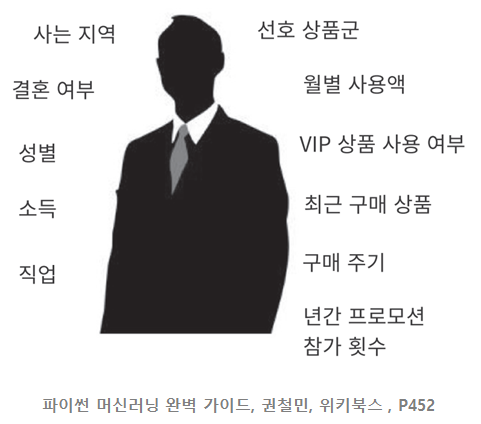

### 고객 세그먼테이션 예제 데이터 셋
- 온라인 판매 데이터를 기반으로 
    - 고객 세그먼테이션을 군집화 기반으로 수행
    
**사용 데이터**
- UCI : Machine Learning Repository에서 다운로드
- http://archive.ics.uci.edu/ml/datasets/online+retail
- Data Foler 클릭
- Online Retail.xslx
- 제품 주문 데이터 세트

### 고객 세그먼테이션 군집화 과정
1. 데이터셋 로딩과 데이터 클린징 
    - 반품이나 CustomerID Null인 데이터는 제외
    - 영국 이외 국가의 데이터는 제외    
    
    
2. RFM 기반 데이터 가공   

    - 구매금액 데이터 생성
    - 고객 기준으로 RFM 가공    
        - 최근 구매일의 기준을 생성해야 함
        
        
3. RFM 기반 고객 세그먼테이션
- Recency, Frequency, Monetary 값의 분포도 확인
- K-Means로 군집화 후에 실루엣 계수 평가
- K-Means 군집화 후에 실루엣 계수 및 군집을 시각화
- 로그 변환 후 재 시각화

- RFM은 Recency, Frequency, Monetary의 약자로 고객의 가치를 다음의 세 가지 기준에 의해 계산하고 있다.

    - Recency - 거래의 최근성: 고객이 얼마나 최근에 구입했는가?
    - Frequency - 거래빈도: 고객이 얼마나 빈번하게 우리 상품을 구입했나?
    - Monetary - 거래규모: 고객이 구입했던 총 금액은 어느 정도인가?


#### 데이터셋 로딩 / 전처리 작업

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel('../data/Online Retail.xlsx')

- 제품 주문 데이터 세트
- InvoiceNo : 주문번호
- StockCode : 제품코드
- 주문량, 주문일자, 제품단가, 주문고객번호, 주문고객국가

In [2]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [14]:
retail_df.describe()
# 개인고객 & 기업고객이 혼재되어 있어 수량의 편차가 매우 높음

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


**영국 이외 국가의 데이터는 제외**

In [15]:
# 수량이나 단가가 0을 초과하는 data만 추출
retail_df=retail_df[retail_df['Quantity']>0]
retail_df=retail_df[retail_df['UnitPrice']>0]

In [16]:
# 고객ID없는 레코드 삭제
retail_df=retail_df[retail_df['CustomerID'].notnull()]

In [18]:
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [6]:
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [20]:
# 주문 고객 국가별 주문수 확인 - 영국이 대다수 차지
# 영국 제외 나머지 국가 삭제
retail_df['Country'].value_counts()
retail_df=retail_df[retail_df['Country']=='United Kingdom']

(354321, 8)


**영국이 대다수를 차지하므로 영국 데이터만 사용**

In [8]:
# 영국만 선택
retail_df=retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)
# 최종데이터 : 354321 건

(354321, 8)


#### RFM 기반 데이터 가공
- 구매 금액 생성
- 고객별 RFM data 생성

In [21]:
retail_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [22]:
# 구매금액 = 주문수량(Quantity)*제품단가(UnitPrice)
retail_df['sale_amount']=retail_df['Quantity']*retail_df['UnitPrice']

In [24]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  object        
 1   StockCode    354321 non-null  object        
 2   Description  354321 non-null  object        
 3   Quantity     354321 non-null  int64         
 4   InvoiceDate  354321 non-null  datetime64[ns]
 5   UnitPrice    354321 non-null  float64       
 6   CustomerID   354321 non-null  float64       
 7   Country      354321 non-null  object        
 8   sale_amount  354321 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 27.0+ MB


In [25]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [27]:
## CustomerID의 식별을 편리하게 하기 위해 int형으로 변환
retail_df['CustomerID']=retail_df['CustomerID'].astype(int)
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  object        
 1   StockCode    354321 non-null  object        
 2   Description  354321 non-null  object        
 3   Quantity     354321 non-null  int64         
 4   InvoiceDate  354321 non-null  datetime64[ns]
 5   UnitPrice    354321 non-null  float64       
 6   CustomerID   354321 non-null  int32         
 7   Country      354321 non-null  object        
 8   sale_amount  354321 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 25.7+ MB


In [30]:
# 고객별 주문건수 확인
retail_df['CustomerID'].value_counts().head(5)
# 특정 고객의 주문건수가 유난히 많은 이유 : 개인고객과 소매(도매)의 주문이 함께 포함

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64

In [33]:
## 고객별 주문액 상위 5위 확인
retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5]
# 특정 고객의 주문 금액이 많음
# 소매점의 주문이 많아서

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64

#### 전처리 작업 필요

**CustomerID**
- 고객 세그먼테이션을 수행하므로
- 고객 식별 번호가 없는 데이터는 필요 없으므로 
- 삭제   


**그외 Data**
- Quantity와 UnitPrice에 음수값 존재 (반환)
- InvoiceNo : C (반환)
- 삭제

* 각 레코드(행)을 유일하게 구별할 수 있는 특성의 조합
    - 전형적인 판매 데이터 세트와 같이 주문번호(InvoiceNo) + 상품코드(StockCode)가 식별자로 되어 있음
    - InvoiceNo + StockCode로 그룹화 수행하면 거의 유일한 식별자 레벨이 될 수 있음
        - 개수의 평균이 1에 가까운 수치로 나옴

In [35]:
retail_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'sale_amount'],
      dtype='object')

In [36]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

#### but, 지금 수행하려는 RFM 기반의 고객 세그먼테이션은  
- 고객 레벨로 주문기간, 주문횟수, 주문금액 데이터를 기반으로 해서 세그먼테이션 수행

- 따라서, 주문번호+상품코드 기준의 데이터를   
    - 고객 기준의 Recency, Frequency, Monetary value 데이터로 변경 필요

1. 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 Group by 수행  
- 현재의 retail_df 데이터 프레임에 CustomerID로 Group by해서 CustomerID 기준으로 데이터 프레임 새롭게 생성  

참고 . 그런데 DataFrame의 groupby()만 사용해서  
여러 개의 칼럼에 서로 다른 aggregation (count()나 max()) 연산을 한 번에 수행하기 어려움  
DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용

**고객 기준으로 Recency, Frequency, Monetary가공**

In [37]:
# Recency(R) : 가장 최근 상품 구입 일에서 오늘까지의 기간
#     - InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency(F) : 상품 구매 횟수 (InvoiceNo 컬럼의 count())
# Monetary value(M) : 총 구매 금액 (sale_amount 컬럼의 sum())
aggregations = {
    'InvoiceDate' : 'max', # 가장 최근 구매일
    'InvoiceNo' : 'count', #총 구매건수
    'sale_amount' : 'sum'    
}
retail_df.groupby('CustomerID').agg(aggregations)

,InvoiceDate,InvoiceNo,sale_amount
CustomerID,,,
12346,2011-01-18 10:01:00,1,77183.60
12747,2011-12-07 14:34:00,103,4196.01
12748,2011-12-09 12:20:00,4595,33719.73
12749,2011-12-06 09:56:00,199,4090.88
12820,2011-12-06 15:12:00,59,942.34
...,...,...,...
18280,2011-03-07 09:52:00,10,180.60
18281,2011-06-12 10:53:00,7,80.82
18282,2011-12-02 11:43:00,12,178.05


### RFM 요인을 변수로 갖고 있는 DF 생성

In [38]:
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)
#Recency - 가장 최근 구매일이기 때문에 가공을 더 진행해야 함

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


**Recency를 날짜에서 정수형으로 가공**
- 온라인 판매기간을 기준으로 가장 최근 주문일로부터 얼마나 지났는지를 계산하여 필드 생성
- Recency = 오늘 날짜 - 가장 죄근 주문일
- 온라인 판매 데이터 판매 기간 확인
    - 2010-12-01 ~ 2011-12-09
    - 따라서 오늘은 하루 더해서 2011-12-10로 설정

#### 온라인 판매기간 확인

In [39]:
retail_df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [40]:
retail_df['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [41]:
### 오늘 : 2011-12-10

import datetime as dt
# 오늘날짜를 2011-12-10으로 지정
dt.datetime(2011,12,10)-cust_df['Recency']
# days가 0이 나오므로 1을 더해서 가장 최근일을 1일전으로 생성

0      325 days 13:59:00
1        2 days 09:26:00
2        0 days 11:40:00
3        3 days 14:04:00
4        3 days 08:48:00
              ...       
3915   277 days 14:08:00
3916   180 days 13:07:00
3917     7 days 12:17:00
3918     3 days 11:58:00
3919    42 days 14:31:00
Name: Recency, Length: 3920, dtype: timedelta64[ns]

In [45]:
cust_df['Recency']=dt.datetime(2011,12,10)-cust_df['Recency'] # 0day가 나옴
cust_df['Recency']=cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 컬럼 건수는 ',cust_df.shape)
cust_df.head(3)

cust_df 로우와 컬럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


### RFM 기반 고객 세그먼테이션
**Recency, Frequency, Monetary 값의 분포도 확인**

#### 온라인 판매 데이터 세트
- 개인 고객 주문 + 소매점 주문
- 소매점 주문이 개인 고객 주문과 매우 큰 차이가 있기 때문에
- 매우 왜곡된 데이터 분포를 가지게 되어
- 군집화가 한쪽 군집에만 집중되는 현상 발생
- 이처럼 왜곡된 데이터 분포에서 군집화를 수행할 때 
- 어떤 현상이 발생하는지 확인

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

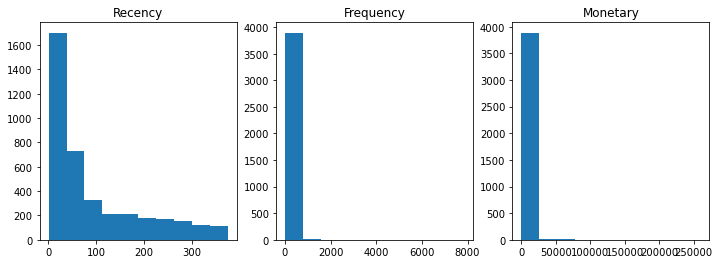

In [49]:
# 히스토그램 확인
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4),nrows=1, ncols=3)

ax1.set_title('Recency')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary')
ax3.hist(cust_df['Monetary'])

#### 결과
- Recency, Frequency, Monetary 모두 왜곡된 데이터 값 분포도를 나타냄
- 특히 Frequency, Monetary의 경우 특정 범위에 값이 몰려 있어서 왜곡 정도가 매우 심함

**각 컬럼의 통계정보 확인**

In [50]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


### K-Means로 군집화 후에 실루엣 계수 평가(왜곡정도가 심한 데이터를 그대로 사용)

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [62]:
# 군집화 수행 : 군집 3개로 구성
kmeans=KMeans(n_clusters=3,random_state=0)
labels=kmeans.fit_predict(cust_df)

In [63]:
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(cust_df,labels)))

실루엣 스코어는 : 0.932


### 결과 : 0.932 
- 이상치에 반응해서 과적합이 이루어짐

왜곡 정도가 매우 높은 데이터 세트에  
K-평균 군집을 적용하면  
중심의  갯수를 증가시키더라도 변별력이 떨어지는   
군집화가 수행됨  

그래서 먼저 평균과 표준편차 재조정한 뒤에  
K-평균 수행

In [67]:
# 평균과 표준편차만 조정 후 군집화 수행
X_features=cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled=StandardScaler().fit_transform(X_features)

In [68]:
# 군집화 수행 : 군집 3개로 구성
kmeans=KMeans(n_clusters=3,random_state=0)
labels=kmeans.fit_predict(X_features_scaled)

In [59]:
cust_df['cluster_label']=labels
cust_df.head()

,CustomerID,Recency,Frequency,Monetary,cluster_label
0,12346,326,1,77183.60,0
1,12747,3,103,4196.01,1
2,12748,1,4595,33719.73,0
3,12749,4,199,4090.88,1
4,12820,4,59,942.34,1


In [69]:
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.592


**K-Means 군집화 후에 실루엣 계수 및 군집을 시각화**

visualize_silhouette() 함수와 visualize_kmeans_plot_multi() 함수 사용 
- visualize_silhouette() : 군집 개수를 변화시키면서 K-평균 군집을 수행했을 때
    - 개별 군집별 평균 실루엣 계수값 시각화하는 함수 (앞에서 사용했음)
- visualize_kmeans_plot_multi() : 군집 개수별로 군집화 구성을 시각화하는 함수

In [70]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

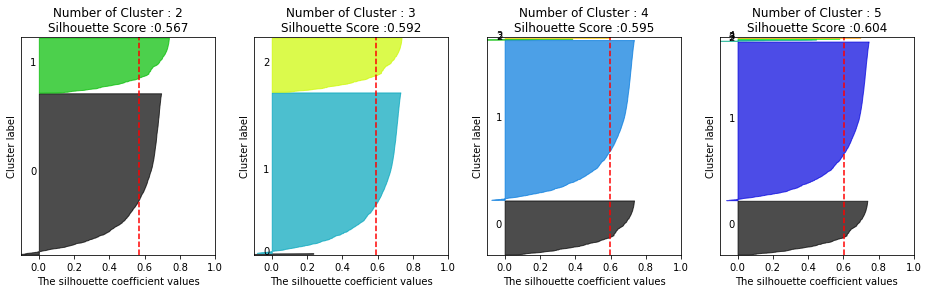

In [71]:
visualize_silhouette([2,3,4,5],X_features_scaled)

#### 그래프 결과
- 군집 2개 
    - 데이터가 평균 계수보다 높은 포인트들이 많이 있지만 0번 군짐의 범위가 너무 넓어서 데이터가 개괄적으로 보임
- 군집 3~5 개
    - 데이터의 양이 너무 작은 군집들이 만들어짐

**데이터 왜곡 정도를 낮추는 로그변환 진행 후 군집-시각화**

In [35]:
### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [72]:
cust_df['Recency_log']= np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)


In [37]:
kmeans=KMeans(n_clusters=3,random_state=0)
labels=kmeans.fit_predict(X_features_scaled) # 로그변환후 표준화
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.303


### 결과
- 실루엣 스코어는 로그 변환하기 전보다 떨어짐
- 절대치보다 개별군집의 균일도를 같이 확인 해야 함

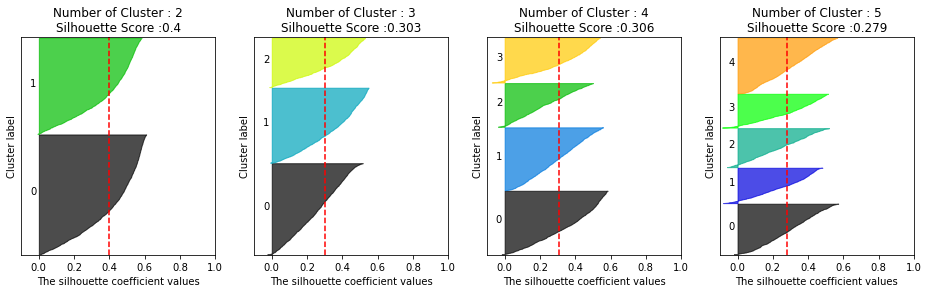

In [73]:
# 로그 변환된 데이터 세트를 기반으로 실루엣 계수와 군집화 구성 시각화

visualize_silhouette([2,3,4,5],X_features_scaled)

### 결과 
- 실루엣스코어는 로그변환하기 전보다 더 떨어졌지만
- 더 균일하게 군집화 구성이 되었음

**왜곡된 데이터세트에 대해서는 로그변환 후 표준 변환을 진행하고 군집화를 수행하면 더 나은 결과를 도출 할 수 있음**